# Analyzing the effect of initial network type on the NB model
Here I will examine whether selecting a particular social network structure affects the patterns that result from simulation of the network-breaking (NB) model. The model normal starts with a random network that is well-mixed with regard to the political identity of individuals. 

**The pattern in question**: Typical runs of the NB model show that decreasing correlation between news sources $\gamma$ results in increasing assortativity in the social network.

## Assortativity
First, I will load in the data for simulations using an intitially random, scale-free, regular, and complete network. 

In [307]:
#--------------------
# Load needed modules
#--------------------
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from dplython import *

#--------------------
# Load data
#--------------------
# Random network (default simulation setting)
rand_data = pd.read_csv("../../../data_derived/network_break/social_networks/assortativity_gammasweep.csv")
rand_data = (rand_data >>
             mutate(delta_assort = X.assort_final - X.assort_initial,
                    network_type = "Random (default)"))

# Scale-free network
sf_data = pd.read_csv("../../../data_derived/network_break/__suppl_analysis/other_network_types/assortativity_scalefree.csv")
sf_data = (sf_data >>
           mutate(delta_assort = X.assort_final - X.assort_initial,
                  network_type = "Scale-free"))

# Regular network
reg_data = pd.read_csv("../../../data_derived/network_break/__suppl_analysis/other_network_types/assortativity_regular.csv")
reg_data = (reg_data >>
            mutate(delta_assort = X.assort_final - X.assort_initial,
                   network_type = "Regular"))

# Complete network (run for 100x longer)
comp_data = pd.read_csv("../../../data_derived/network_break/__suppl_analysis/other_network_types/assortativity_complete-longsim.csv")
comp_data = (comp_data >>
             mutate(delta_assort = X.assort_final - X.assort_initial,
                    network_type = "Complete (100x longer)"))

# Bind together and summarise
network_list = ["Random (default)", "Regular", "Scale-free", "Complete (100x longer)"]
assort_data = pd.concat([rand_data, sf_data, reg_data, comp_data])
assort_data = assort_data.drop(columns = ["replicate"])
assort_data = pd.melt(assort_data, id_vars = ["gamma", "network_type"], var_name = "metric", value_name = "value")
assort_sum = (assort_data >>
               group_by(X.gamma, X.network_type, X.metric) >>
               summarize(mean = np.mean(X.value),
                         sd = np.std(X.value),
                         replicates = X.value.__len__()) >>
               mutate(ci95 = 1.96*X.sd / X.replicates**0.5,
                      network_type = X.network_type.astype('category').cat.reorder_categories(network_list)))

Let's see how intitial network structure affects the pattern of assortativity that emerges over the course of the simluation. 

Typically, simulations have networks with mean degree $<k> = 5$; however, with a complete network, all nodes have degree $k = N-1$. Therefore, we ran simulations that started with complete networks for 100 times longer (i.e., 10,000,000 time steps). This would allow us to see if complete networks would eventually converge on the same network structure as other, lower mean-degree networks. 

In [308]:

def theme_ctokita():
    return (p9.theme_classic() + 
            p9.theme(axis_text       = element_text(size = 7, color = "black"),
                     axis_title      = element_text(size = 9, color = "black"),
                     axis_ticks      = element_line(size = 1, color = "black"),
                     axis_line       = element_line(size = 1, color = "black"),
                     legend_title    = element_text(size = 8, face = "bold", vjust = -1),
                     legend_text     = element_text(size = 7, color = "black"),
                     strip_text      = element_text(size = 8, color = "black"),
                     legend_key_size = 5,
                     aspect_ratio    = 1,
                     figure_size     = (2, 2),
                     dpi = 225))


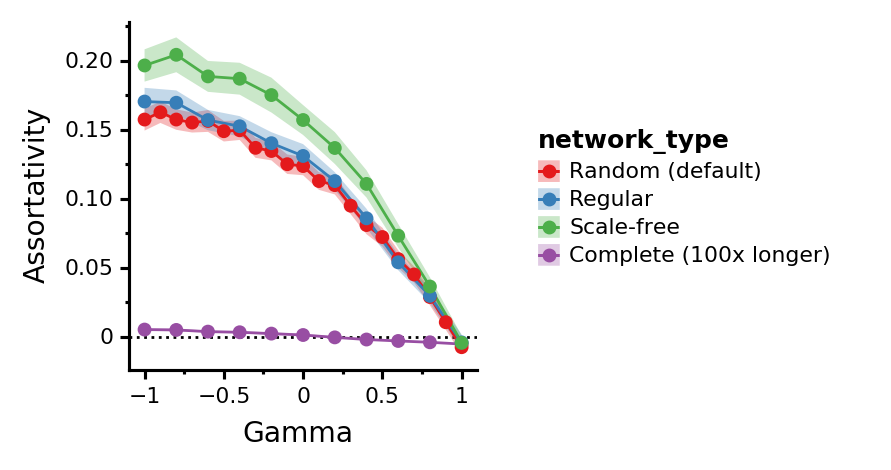

<ggplot: (7024279525)>

In [309]:
# Filter data just to final assortativity
assort_final = (assort_sum >>
                sift(X.metric == "assort_final"))

# Bring in necessary modules and custom plotting theme
import sys
sys.path.append("/Users/ChrisTokita/Documents/Research/Tarnita Lab/Information Cascades/information-cascades/scripts/")
# from _plot_themes.plot_theme_ctokita import theme_ctokita
import plotnine as p9

# Plot
pal = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]
gg_assort_nettype = (p9.ggplot(assort_final, aes(x = 'gamma', y = 'mean', color = 'network_type', fill = 'network_type')) +
                     p9.geom_hline(aes(yintercept = 0),
                                  linetype = "dotted") +
                     p9.geom_ribbon(aes(ymin = 'mean - ci95', ymax = 'mean + ci95'),
                                alpha = 0.3,
                                color = None) +
                     p9.geom_line() +
                     p9.geom_point() +
                     p9.scale_color_manual(pal) +
                     p9.scale_fill_manual(pal) +
                     p9.xlab('Gamma') +
                     p9.ylab('Assortativity') +
                     theme_ctokita())
gg_assort_nettype